# Time Series Preprocessing Pipeline for Flight Delay Data

This notebook builds upon the base preprocessing pipeline to create features specifically optimized for time series models such as ARIMA, Prophet, and other forecasting algorithms. Time series analysis requires specific preprocessing steps including proper temporal aggregation, handling of seasonality, and preparation of lagged features.

## Key Processing Steps:
1. Loading the base preprocessed data
2. Temporal aggregation (daily, hourly)
3. Time series feature engineering (lags, rolling windows)
4. Handling seasonality
5. Stationarity testing and transformations
6. Creation of exogenous variables
7. Time-based train-test splits with forecast horizon
8. Exporting the processed data for time series model training

In [114]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
import pickle

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
BASE_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'base_preprocessed_flights.csv')
TS_PROCESSED_PATH = path.join(project_root, 'data', 'processed', 'ts_ready_flights')
TS_MODEL_PATH = path.join(project_root, 'models', 'ts')

# Create directories if they don't exist
os.makedirs(os.path.dirname(TS_PROCESSED_PATH), exist_ok=True)
os.makedirs(TS_MODEL_PATH, exist_ok=True)

print(f"Base processed data path: {BASE_PROCESSED_PATH}")
print(f"Time Series processed data path: {TS_PROCESSED_PATH}")
print(f"Time Series model path: {TS_MODEL_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Base processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
Time Series processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights
Time Series model path: c:\xampp\htdocs\Forecasting_Flights-DataScience\models\ts
Libraries and paths configured.
Libraries and paths configured.


In [115]:
# Function to load data in chunks
def load_processed_data(file_path, chunk_size=500000):
    """
    Generator function to load preprocessed data in chunks
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        yield chunk

In [116]:
# Inspect the data
first_chunk = next(load_processed_data(BASE_PROCESSED_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

Data shape of first chunk: (500000, 28)

Columns and data types:
- FL_DATE: datetime64[ns]
- ORIGIN: object
- DEST: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- YEAR: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- QUARTER: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample data (first 5 rows):


,FL_DATE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,QUARTER,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,FLL,EWR,715,711,-4.0,19.0,1210.0,1443.0,4.0,901,1447.0,-14.0,0,NaN,0,186.0,153.0,1065.0,2019,1,9,3,1,1,0,11,Morning
1,2022-11-19,MSP,SEA,1280,1274,-6.0,9.0,2123.0,2232.0,38.0,1395,2310.0,-5.0,0,NaN,0,235.0,189.0,1399.0,2022,11,19,6,4,4,1,21,Evening
2,2022-07-22,DEN,MSP,594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,87.0,680.0,2022,7,22,5,3,3,0,9,Morning
3,2023-03-06,MSP,SFO,969,968,-1.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,249.0,1589.0,2023,3,6,1,1,2,0,16,Afternoon
4,2019-07-31,DAL,OKC,610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,36.0,181.0,2019,7,31,3,3,3,0,10,Morning


In [117]:
# --- MISSING VALUE HANDLING FOR TS PIPELINE ---
def drop_columns_with_high_missing(df, threshold=0.5):
    """
    Drop columns with >= threshold proportion of missing values.
    """
    missing_ratio = df.isnull().mean(axis=0)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()
    if cols_to_drop:
        print(f"Dropping columns with >= {int(threshold*100)}% missing values: {cols_to_drop}")
    return df.drop(columns=cols_to_drop)

# Example usage: apply after loading each chunk or after concatenating all data
# For demonstration, add to the start of your main TS pipeline after loading/concatenating data

# ...existing code...
# Example: After loading ts_daily_featured, drop columns with >=50% missing values
# ts_daily_featured = drop_columns_with_high_missing(ts_daily_featured, threshold=0.5)
# ...existing code...

In [118]:
# Check missing values in each column after dropping columns with high missingness
df_after_drop = drop_columns_with_high_missing(first_chunk, threshold=0.5)
missing_counts = df_after_drop.isnull().sum()
missing_percent = df_after_drop.isnull().mean() * 100

print("Missing values per column (after dropping high-missing columns):")
for col in df_after_drop.columns:
    print(f"- {col}: {missing_counts[col]} missing ({missing_percent[col]:.2f}%)")

Dropping columns with >= 50% missing values: ['CANCELLATION_CODE']
Missing values per column (after dropping high-missing columns):
- FL_DATE: 0 missing (0.00%)
- ORIGIN: 0 missing (0.00%)
- DEST: 0 missing (0.00%)
- CRS_DEP_TIME: 0 missing (0.00%)
- DEP_TIME: 0 missing (0.00%)
- DEP_DELAY: 0 missing (0.00%)
- TAXI_OUT: 0 missing (0.00%)
- WHEELS_OFF: 0 missing (0.00%)
- WHEELS_ON: 134 missing (0.03%)
- TAXI_IN: 134 missing (0.03%)
- CRS_ARR_TIME: 0 missing (0.00%)
- ARR_TIME: 134 missing (0.03%)
- ARR_DELAY: 1240 missing (0.25%)
- CANCELLED: 0 missing (0.00%)
- DIVERTED: 0 missing (0.00%)
- CRS_ELAPSED_TIME: 0 missing (0.00%)
- AIR_TIME: 1240 missing (0.25%)
- DISTANCE: 0 missing (0.00%)
- YEAR: 0 missing (0.00%)
- MONTH: 0 missing (0.00%)
- DAY_OF_MONTH: 0 missing (0.00%)
- DAY_OF_WEEK: 0 missing (0.00%)
- QUARTER: 0 missing (0.00%)
- SEASON: 0 missing (0.00%)
- IS_HOLIDAY_SEASON: 0 missing (0.00%)
- DEP_HOUR: 0 missing (0.00%)
- TIME_OF_DAY: 0 missing (0.00%)
Missing values per colu

## Time Series Pre-analysis

Before we dive into preprocessing for time series models, let's first analyze the time series characteristics of our flight delay data to inform our approach.

In [119]:
# Aggregate data by date for time series analysis
def aggregate_to_time_series(chunks, agg_level='daily', target_col='DEP_DELAY'):
    """
    Aggregate flight data into time series at different temporal resolutions
    
    Parameters:
    -----------
    chunks : generator
        Generator of data chunks
    agg_level : str
        Level of aggregation ('daily', 'hourly', 'airport_daily', 'carrier_daily')
    target_col : str
        Column to aggregate (typically delay)
    
    Returns:
    --------
    pd.DataFrame
        Aggregated time series data
    """
    # Dictionary to store aggregated data
    agg_data = {}
    
    for chunk in chunks:
        # Ensure we have date information
        if 'FL_DATE' not in chunk.columns:
            print("Error: FL_DATE column not found")
            return None
        
        # Define groupby columns based on aggregation level
        if agg_level == 'daily':
            groupby_cols = ['FL_DATE']
        elif agg_level == 'hourly':
            if 'DEP_HOUR' in chunk.columns:
                chunk['DATETIME'] = chunk['FL_DATE'] + pd.to_timedelta(chunk['DEP_HOUR'], unit='h')
                groupby_cols = ['DATETIME']
            else:
                print("Error: DEP_HOUR column not found for hourly aggregation")
                return None
        elif agg_level == 'airport_daily':
            if 'ORIGIN' in chunk.columns:
                groupby_cols = ['FL_DATE', 'ORIGIN']
            else:
                print("Error: ORIGIN column not found for airport_daily aggregation")
                return None
        elif agg_level == 'carrier_daily':
            if 'OP_CARRIER' in chunk.columns:
                groupby_cols = ['FL_DATE', 'OP_CARRIER']
            else:
                print("Error: OP_CARRIER column not found for carrier_daily aggregation")
                return None
        else:
            print(f"Error: Unknown aggregation level: {agg_level}")
            return None
        
        # Skip chunk if target column is not present
        if target_col not in chunk.columns:
            continue
        
        # Aggregate data
        agg = chunk.groupby(groupby_cols).agg(
            avg_delay=(target_col, 'mean'),
            median_delay=(target_col, 'median'),
            max_delay=(target_col, 'max'),
            min_delay=(target_col, 'min'),
            std_delay=(target_col, 'std'),
            num_flights=(target_col, 'count')
        )
        
        # Process aggregated chunk
        for idx, row in agg.iterrows():
            if isinstance(idx, tuple):
                # Multi-index case (airport or carrier level)
                date = idx[0]
                entity = idx[1]
                
                # Create a composite key
                key = (date, entity)
                
                if key in agg_data:
                    # Update existing entry with weighted average
                    total_flights = agg_data[key]['num_flights'] + row['num_flights']
                    agg_data[key]['avg_delay'] = (
                        (agg_data[key]['avg_delay'] * agg_data[key]['num_flights'] +
                         row['avg_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[key]['median_delay'] = (
                        (agg_data[key]['median_delay'] * agg_data[key]['num_flights'] +
                         row['median_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[key]['max_delay'] = max(agg_data[key]['max_delay'], row['max_delay'])
                    agg_data[key]['min_delay'] = min(agg_data[key]['min_delay'], row['min_delay'])
                    agg_data[key]['num_flights'] = total_flights
                else:
                    # Create new entry
                    agg_data[key] = {
                        'date': date,
                        'entity': entity,
                        'avg_delay': row['avg_delay'],
                        'median_delay': row['median_delay'],
                        'max_delay': row['max_delay'],
                        'min_delay': row['min_delay'],
                        'std_delay': row['std_delay'],
                        'num_flights': row['num_flights']
                    }
            else:
                # Single index case (daily or hourly)
                date = idx
                
                if date in agg_data:
                    # Update existing entry with weighted average
                    total_flights = agg_data[date]['num_flights'] + row['num_flights']
                    agg_data[date]['avg_delay'] = (
                        (agg_data[date]['avg_delay'] * agg_data[date]['num_flights'] +
                         row['avg_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[date]['median_delay'] = (
                        (agg_data[date]['median_delay'] * agg_data[date]['num_flights'] +
                         row['median_delay'] * row['num_flights']) / total_flights
                    )
                    agg_data[date]['max_delay'] = max(agg_data[date]['max_delay'], row['max_delay'])
                    agg_data[date]['min_delay'] = min(agg_data[date]['min_delay'], row['min_delay'])
                    agg_data[date]['num_flights'] = total_flights
                else:
                    # Create new entry
                    agg_data[date] = {
                        'date': date,
                        'avg_delay': row['avg_delay'],
                        'median_delay': row['median_delay'],
                        'max_delay': row['max_delay'],
                        'min_delay': row['min_delay'],
                        'std_delay': row['std_delay'],
                        'num_flights': row['num_flights']
                    }
    
    # Convert aggregated data to DataFrame
    if 'entity' in next(iter(agg_data.values())):
        # Multi-index case
        df_agg = pd.DataFrame([
            {'date': v['date'], 'entity': v['entity'], 'avg_delay': v['avg_delay'],
             'median_delay': v['median_delay'], 'max_delay': v['max_delay'],
             'min_delay': v['min_delay'], 'std_delay': v['std_delay'],
             'num_flights': v['num_flights']}
            for v in agg_data.values()
        ])
        
        # Set index
        df_agg = df_agg.set_index(['date', 'entity'])
        
    else:
        # Single index case
        df_agg = pd.DataFrame([
            {'date': v['date'], 'avg_delay': v['avg_delay'],
             'median_delay': v['median_delay'], 'max_delay': v['max_delay'],
             'min_delay': v['min_delay'], 'std_delay': v['std_delay'],
             'num_flights': v['num_flights']}
            for v in agg_data.values()
        ])
        
        # Set index
        df_agg = df_agg.set_index('date')
    
    # Sort by date
    df_agg = df_agg.sort_index()
    
    return df_agg

Daily time series shape: (1338, 6)

First few rows:


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights
date,,,,,,
2019-01-01,10.529989,-1.004907,341.0,-30.0,30.763833,1834.0
2019-01-02,12.479763,-0.599704,818.0,-19.0,42.575954,2026.0
2019-01-03,10.310448,-1.690547,1394.0,-26.0,48.035198,2010.0
2019-01-04,5.157555,-2.208250,672.0,-41.0,42.244972,2012.0
2019-01-05,7.342874,-2.428154,667.0,-20.0,44.961260,1712.0


Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00
Total days: 1338


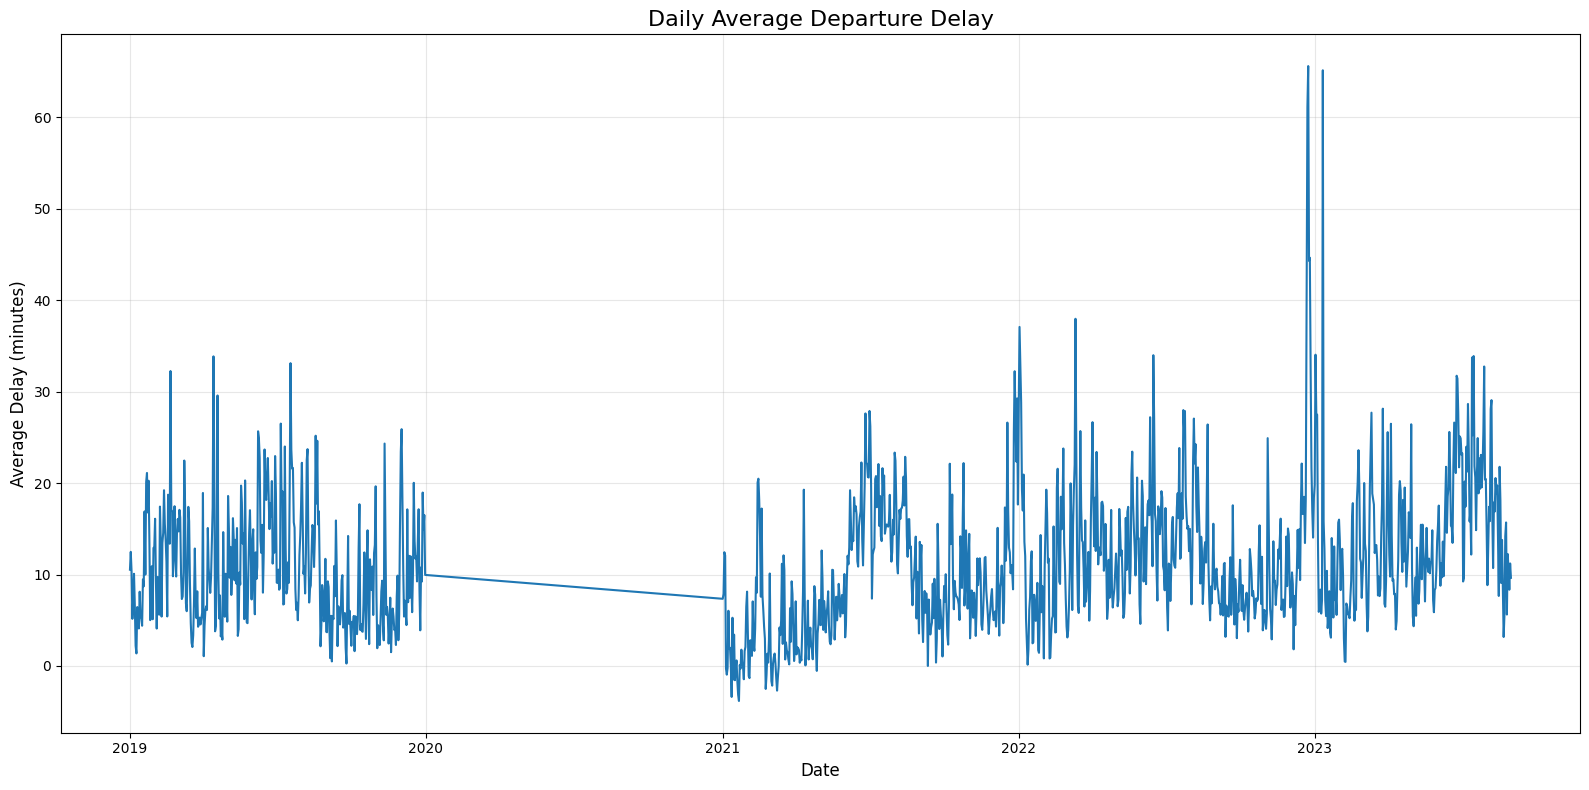

In [120]:
# Create and analyze daily aggregated time series
ts_daily = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='daily')

print(f"Daily time series shape: {ts_daily.shape}")
print("\nFirst few rows:")
display(ts_daily.head())

# Check the date range
print(f"Date range: {ts_daily.index.min()} to {ts_daily.index.max()}")
print(f"Total days: {len(ts_daily)}")

# Plot the time series
plt.figure(figsize=(16, 8))
plt.plot(ts_daily.index, ts_daily['avg_delay'], linewidth=1.5)
plt.title('Daily Average Departure Delay', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [121]:
# Check for stationarity
def check_stationarity(ts, column='avg_delay'):
    """
    Check if a time series is stationary using the Augmented Dickey-Fuller test
    """
    # Calculate rolling statistics
    rolling_mean = ts[column].rolling(window=7).mean()
    rolling_std = ts[column].rolling(window=7).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(16, 8))
    plt.subplot(211)
    plt.plot(ts.index, ts[column], label='Original')
    plt.plot(ts.index, rolling_mean, label='Rolling Mean (7-day)')
    plt.plot(ts.index, rolling_std, label='Rolling Std (7-day)')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # Perform ADF test
    result = adfuller(ts[column].dropna())
    
    plt.subplot(212)
    plt.bar(['ADF Statistic', 'p-value', '1%', '5%', '10%'], 
            [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']], 
            color=['blue', 'red', 'green', 'green', 'green'])
    plt.axhline(y=result[4]['5%'], color='green', linestyle='-', alpha=0.5)
    plt.title('Augmented Dickey-Fuller Test Results', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print test results
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interpret results
    if result[1] <= 0.05:
        print("\nConclusion: Time series is stationary (reject null hypothesis)")
        return True
    else:
        print("\nConclusion: Time series is non-stationary (fail to reject null hypothesis)")
        return False

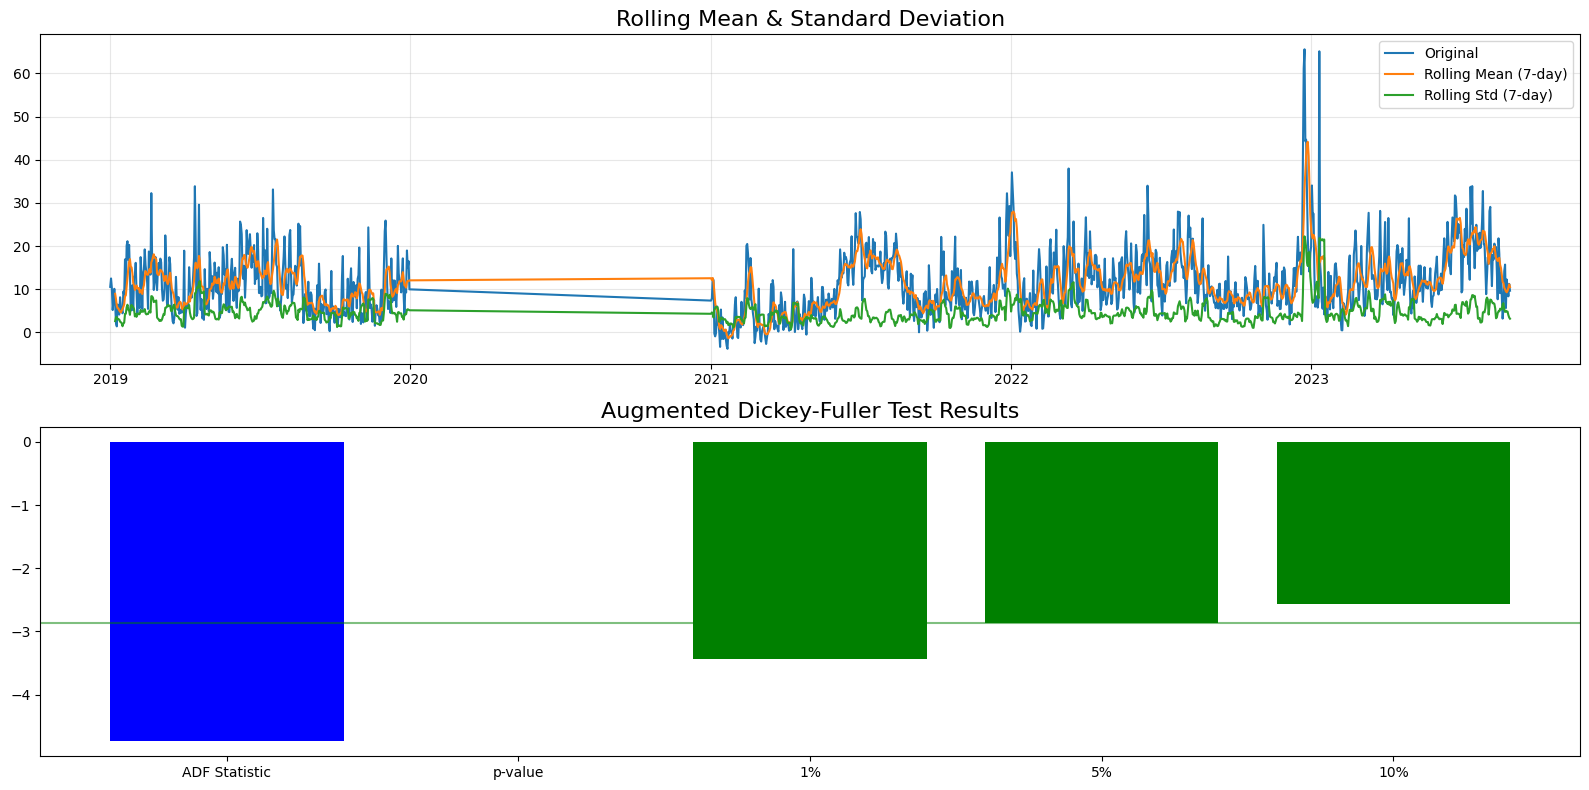

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.7388
p-value: 0.0001
Critical Values:
   1%: -3.4353
   5%: -2.8637
   10%: -2.5679

Conclusion: Time series is stationary (reject null hypothesis)


In [122]:
# Check stationarity of the daily average delay time series
is_stationary = check_stationarity(ts_daily)

# If not stationary, demonstrate differencing
if not is_stationary:
    # First-order differencing
    ts_daily['diff1'] = ts_daily['avg_delay'].diff().dropna()
    
    # Check stationarity of differenced series
    print("\nChecking stationarity after first-order differencing:")
    is_stationary_diff1 = check_stationarity(ts_daily.dropna(), column='diff1')

In [123]:
# Seasonal decomposition
def decompose_time_series(ts, column='avg_delay'):
    """
    Decompose time series into trend, seasonal, and residual components
    """
    # Fill any missing values with forward fill
    ts_filled = ts[column].fillna(method='ffill')
    
    # Check if we have enough data for decomposition
    if len(ts_filled) < 14:  # Need at least twice the period for weekly seasonality
        print("Not enough data for decomposition")
        return None
    
    # Perform seasonal decomposition with additive model
    try:
        decomposition = seasonal_decompose(ts_filled, model='additive', period=7)  # Weekly seasonality
        
        # Plot decomposition
        plt.figure(figsize=(16, 12))
        
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title('Observed', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title('Trend', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title('Seasonality (Weekly)', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title('Residuals', fontsize=16)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return decomposition
    except Exception as e:
        print(f"Error during decomposition: {e}")
        return None

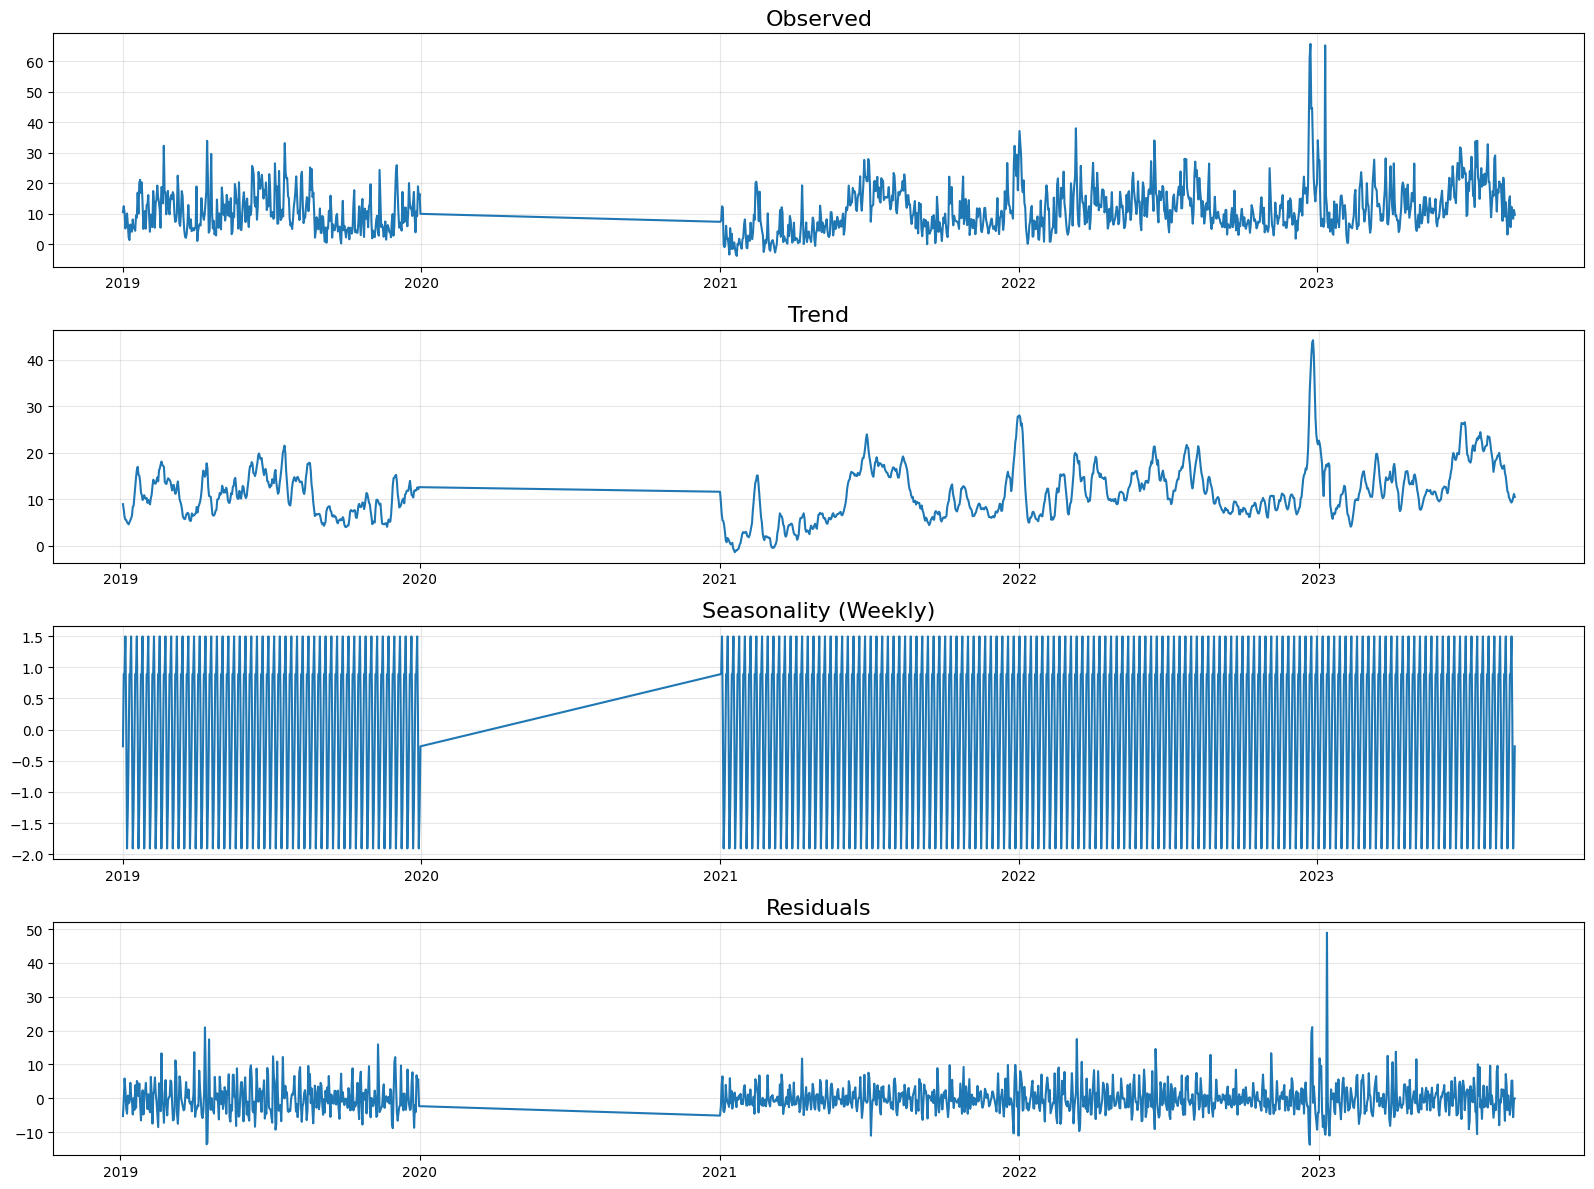

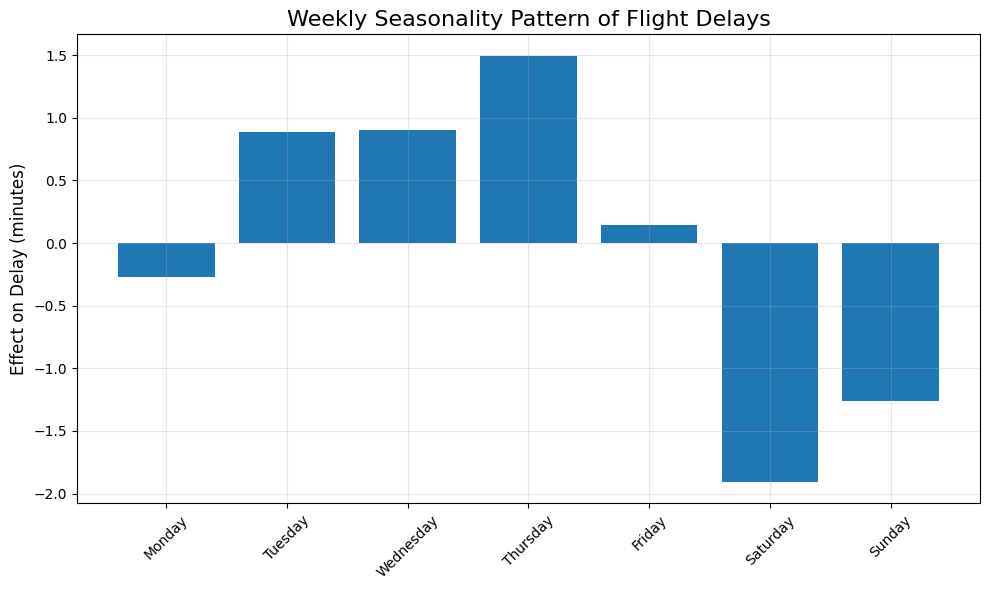

In [124]:
# Decompose the time series to understand seasonality patterns
decomposition = decompose_time_series(ts_daily)

# Analyze the weekly seasonality pattern if we have valid decomposition
if decomposition is not None:
    # Extract seasonal pattern (should be of length 7 for weekly)
    seasonal_pattern = decomposition.seasonal[:7]
    
    # Create day labels
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Plot the weekly pattern
    plt.figure(figsize=(10, 6))
    plt.bar(days, seasonal_pattern)
    plt.title('Weekly Seasonality Pattern of Flight Delays', fontsize=16)
    plt.ylabel('Effect on Delay (minutes)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [125]:
# Analyze ACF and PACF plots for time series modeling
def analyze_acf_pacf(ts, column='avg_delay', lags=40):
    """
    Analyze auto-correlation and partial auto-correlation functions
    """
    # Fill missing values
    ts_filled = ts[column].fillna(method='ffill')
    
    # Create the plots
    plt.figure(figsize=(16, 8))
    
    plt.subplot(211)
    plot_acf(ts_filled, lags=lags, alpha=0.05, title='Autocorrelation Function (ACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.subplot(212)
    plot_pacf(ts_filled, lags=lags, alpha=0.05, method='ols', title='Partial Autocorrelation Function (PACF)', ax=plt.gca())
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

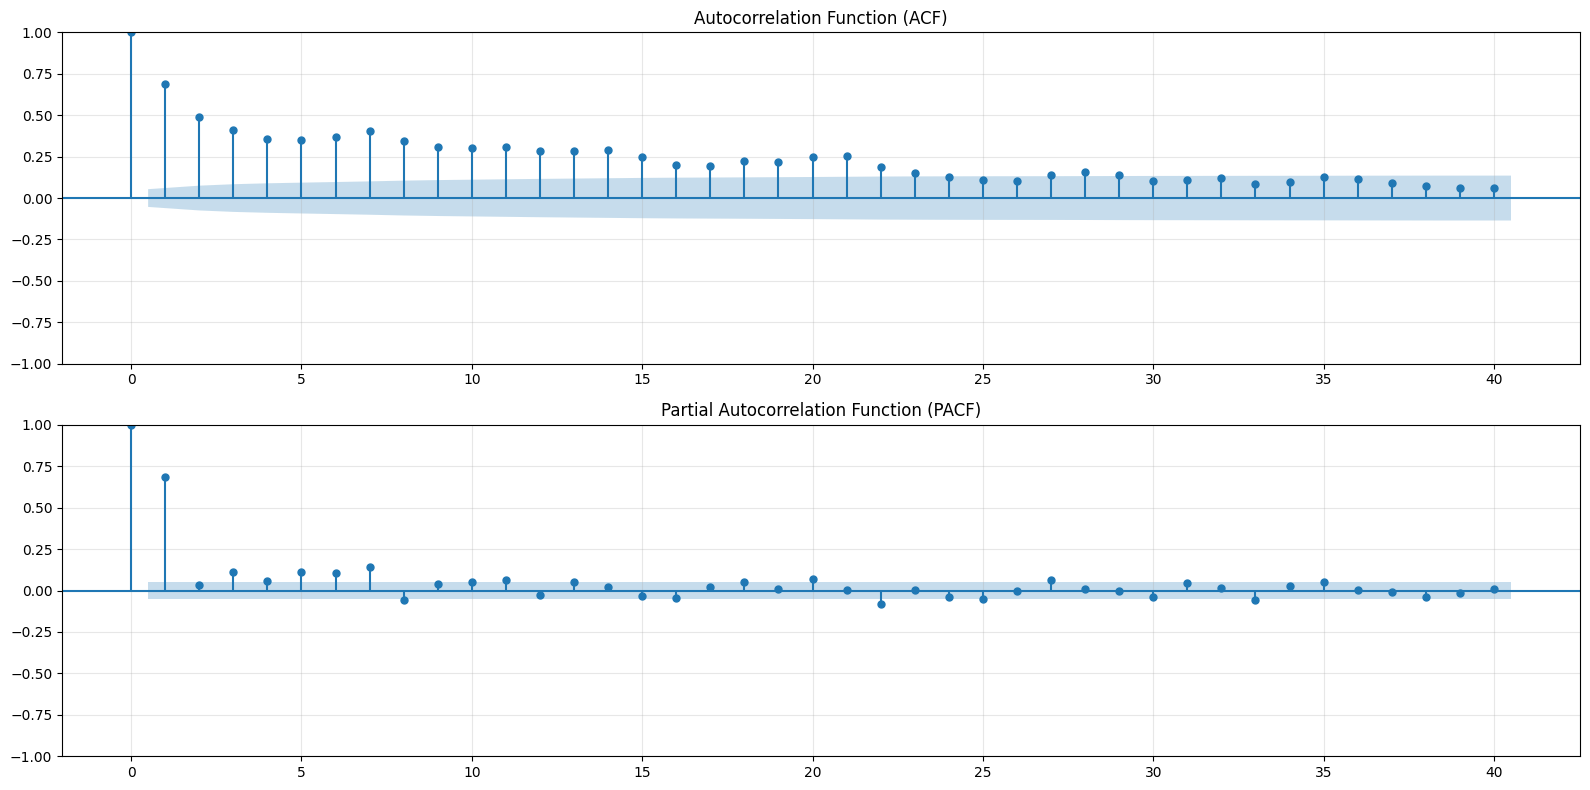

In [126]:
# Analyze ACF and PACF to guide model selection
analyze_acf_pacf(ts_daily)

## Feature Engineering for Time Series Models

Based on our analysis, we'll create features specifically designed for time series forecasting. These include:
1. Lag features
2. Rolling statistics
3. Seasonal indicators
4. Holiday indicators
5. External regressors (e.g., weather data, if available)

In [127]:
# Create time series features for forecasting
def create_ts_features(ts_data):
    """
    Create features for time series forecasting
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # ======== LAG FEATURES ========
    # Create lags of the target variable (useful for autoregressive models)
    for lag in [1, 2, 3, 7, 14, 21, 28]:  # Daily, weekly, and monthly lags
        ts[f'avg_delay_lag{lag}'] = ts['avg_delay'].shift(lag)
    
    # ======== ROLLING WINDOW FEATURES ========
    # Create rolling statistics
    for window in [3, 7, 14, 28]:
        ts[f'avg_delay_roll_mean{window}'] = ts['avg_delay'].rolling(window=window).mean()
        ts[f'avg_delay_roll_std{window}'] = ts['avg_delay'].rolling(window=window).std()
        ts[f'avg_delay_roll_max{window}'] = ts['avg_delay'].rolling(window=window).max()
        ts[f'avg_delay_roll_min{window}'] = ts['avg_delay'].rolling(window=window).min()
    
    # ======== CALENDAR FEATURES ========
    # Extract date components
    if isinstance(ts.index, pd.DatetimeIndex):
        # Add calendar features
        ts['month'] = ts.index.month
        ts['day_of_week'] = ts.index.dayofweek  # 0=Monday, 6=Sunday
        ts['day_of_year'] = ts.index.dayofyear
        ts['quarter'] = ts.index.quarter
        ts['week_of_year'] = ts.index.isocalendar().week
        
        # Add cyclical encoding of calendar features
        ts['month_sin'] = np.sin(2 * np.pi * ts['month'] / 12)
        ts['month_cos'] = np.cos(2 * np.pi * ts['month'] / 12)
        ts['day_of_week_sin'] = np.sin(2 * np.pi * ts['day_of_week'] / 7)
        ts['day_of_week_cos'] = np.cos(2 * np.pi * ts['day_of_week'] / 7)
        
        # Create weekend indicator
        ts['is_weekend'] = (ts['day_of_week'] >= 5).astype(int)
    
    # ======== TREND FEATURES ========
    # Create a simple trend feature (days since start)
    if isinstance(ts.index, pd.DatetimeIndex):
        ts['trend'] = (ts.index - ts.index.min()).days
    
    return ts

In [128]:
# Create holiday indicators
def add_holiday_indicators(ts_data):
    """
    Add holiday indicators to the time series data
    """
    # Make a copy to avoid modifying the original data
    ts = ts_data.copy()
    
    # Check that index is a datetime index
    if not isinstance(ts.index, pd.DatetimeIndex):
        print("Error: Index is not a DatetimeIndex")
        return ts
    
    # Initialize holiday columns
    ts['is_holiday'] = 0
    ts['is_holiday_season'] = 0
    
    # Get years in the data
    years = ts.index.year.unique()
    
    # Define major US holidays (simplified version)
    holidays = []
    for year in years:
        # New Year's Day
        holidays.append(pd.Timestamp(year=year, month=1, day=1))
        
        # Memorial Day (last Monday in May)
        memorial_day = pd.Timestamp(year=year, month=5, day=31)
        memorial_day = memorial_day - pd.Timedelta(days=(memorial_day.dayofweek - 0) % 7)
        holidays.append(memorial_day)
        
        # Independence Day
        holidays.append(pd.Timestamp(year=year, month=7, day=4))
        
        # Labor Day (first Monday in September)
        labor_day = pd.Timestamp(year=year, month=9, day=1)
        labor_day = labor_day + pd.Timedelta(days=(0 - labor_day.dayofweek) % 7)
        holidays.append(labor_day)
        
        # Thanksgiving (fourth Thursday in November)
        thanksgiving = pd.Timestamp(year=year, month=11, day=1)
        thanksgiving = thanksgiving + pd.Timedelta(days=(3 - thanksgiving.dayofweek) % 7 + 21)
        holidays.append(thanksgiving)
        
        # Christmas
        holidays.append(pd.Timestamp(year=year, month=12, day=25))
    
    # Mark holidays
    for holiday in holidays:
        # Mark the actual holiday
        if holiday in ts.index:
            ts.loc[holiday, 'is_holiday'] = 1
        
        # Mark days before and after as holiday-adjacent (for travel effects)
        for i in range(1, 3):  # 1-2 days before and after
            before = holiday - pd.Timedelta(days=i)
            after = holiday + pd.Timedelta(days=i)
            
            if before in ts.index:
                ts.loc[before, 'is_holiday'] = 0.5  # Half weight for adjacent days
            
            if after in ts.index:
                ts.loc[after, 'is_holiday'] = 0.5  # Half weight for adjacent days
    
    # Mark holiday seasons (Nov 15 - Jan 15)
    for year in years:
        # Thanksgiving to New Year's season
        season_start = pd.Timestamp(year=year, month=11, day=15)
        season_end = pd.Timestamp(year=year+1, month=1, day=15)
        
        # Mark the holiday season
        mask = (ts.index >= season_start) & (ts.index <= season_end)
        ts.loc[mask, 'is_holiday_season'] = 1
    
    return ts

In [129]:
# Process features for time series forecasting
ts_daily_featured = create_ts_features(ts_daily)
ts_daily_featured = add_holiday_indicators(ts_daily_featured)

print(f"Time series with features shape: {ts_daily_featured.shape}")
print("\nFeatures created:")
for col in ts_daily_featured.columns:
    print(f"- {col}")

# Show a sample of the featured data
display(ts_daily_featured.head())

Time series with features shape: (1338, 42)

Features created:
- avg_delay
- median_delay
- max_delay
- min_delay
- std_delay
- num_flights
- avg_delay_lag1
- avg_delay_lag2
- avg_delay_lag3
- avg_delay_lag7
- avg_delay_lag14
- avg_delay_lag21
- avg_delay_lag28
- avg_delay_roll_mean3
- avg_delay_roll_std3
- avg_delay_roll_max3
- avg_delay_roll_min3
- avg_delay_roll_mean7
- avg_delay_roll_std7
- avg_delay_roll_max7
- avg_delay_roll_min7
- avg_delay_roll_mean14
- avg_delay_roll_std14
- avg_delay_roll_max14
- avg_delay_roll_min14
- avg_delay_roll_mean28
- avg_delay_roll_std28
- avg_delay_roll_max28
- avg_delay_roll_min28
- month
- day_of_week
- day_of_year
- quarter
- week_of_year
- month_sin
- month_cos
- day_of_week_sin
- day_of_week_cos
- is_weekend
- trend
- is_holiday
- is_holiday_season


,avg_delay,median_delay,max_delay,min_delay,std_delay,num_flights,avg_delay_lag1,avg_delay_lag2,avg_delay_lag3,avg_delay_lag7,avg_delay_lag14,avg_delay_lag21,avg_delay_lag28,avg_delay_roll_mean3,avg_delay_roll_std3,avg_delay_roll_max3,avg_delay_roll_min3,avg_delay_roll_mean7,avg_delay_roll_std7,avg_delay_roll_max7,avg_delay_roll_min7,avg_delay_roll_mean14,avg_delay_roll_std14,avg_delay_roll_max14,avg_delay_roll_min14,avg_delay_roll_mean28,avg_delay_roll_std28,avg_delay_roll_max28,avg_delay_roll_min28,month,day_of_week,day_of_year,quarter,week_of_year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,is_weekend,trend,is_holiday,is_holiday_season
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,10.529989,-1.004907,341.0,-30.0,30.763833,1834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,0.5,0.866025,0.781831,0.623490,0,0,1.0,0
2019-01-02,12.479763,-0.599704,818.0,-19.0,42.575954,2026.0,10.529989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,2,1,1,0.5,0.866025,0.974928,-0.222521,0,1,0.5,0
2019-01-03,10.310448,-1.690547,1394.0,-26.0,48.035198,2010.0,12.479763,10.529989,NaN,NaN,NaN,NaN,NaN,11.106733,1.194135,12.479763,10.310448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,3,1,1,0.5,0.866025,0.433884,-0.900969,0,2,0.5,0
2019-01-04,5.157555,-2.208250,672.0,-41.0,42.244972,2012.0,10.310448,12.479763,10.529989,NaN,NaN,NaN,NaN,9.315922,3.761050,12.479763,5.157555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,4,4,1,1,0.5,0.866025,-0.433884,-0.900969,0,3,0.0,0
2019-01-05,7.342874,-2.428154,667.0,-20.0,44.961260,1712.0,5.157555,10.310448,12.479763,NaN,NaN,NaN,NaN,7.603625,2.586324,10.310448,5.157555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,5,1,1,0.5,0.866025,-0.974928,-0.222521,1,4,0.0,0


Full per-flight dataset size after dropping full duplicates: 2470191 rows
Train set: 1345137 rows from 2019-01-01 00:00:00 to 2021-12-31 00:00:00
Test set: 1125054 rows from 2022-01-01 00:00:00 to 2023-08-31 00:00:00
Train set: 1345137 rows from 2019-01-01 00:00:00 to 2021-12-31 00:00:00
Test set: 1125054 rows from 2022-01-01 00:00:00 to 2023-08-31 00:00:00
Final per-flight delay output shape: (2470191, 2)
Final per-flight delay output shape: (2470191, 2)


,FL_DATE,DEP_DELAY
0,2019-01-01,-1.0
1,2019-01-01,-5.0
2,2019-01-01,2.0
3,2019-01-01,-2.0
4,2019-01-01,-6.0


Saved per_flight_delay_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\per_flight_delay_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\per_flight_delay_ts.pkl


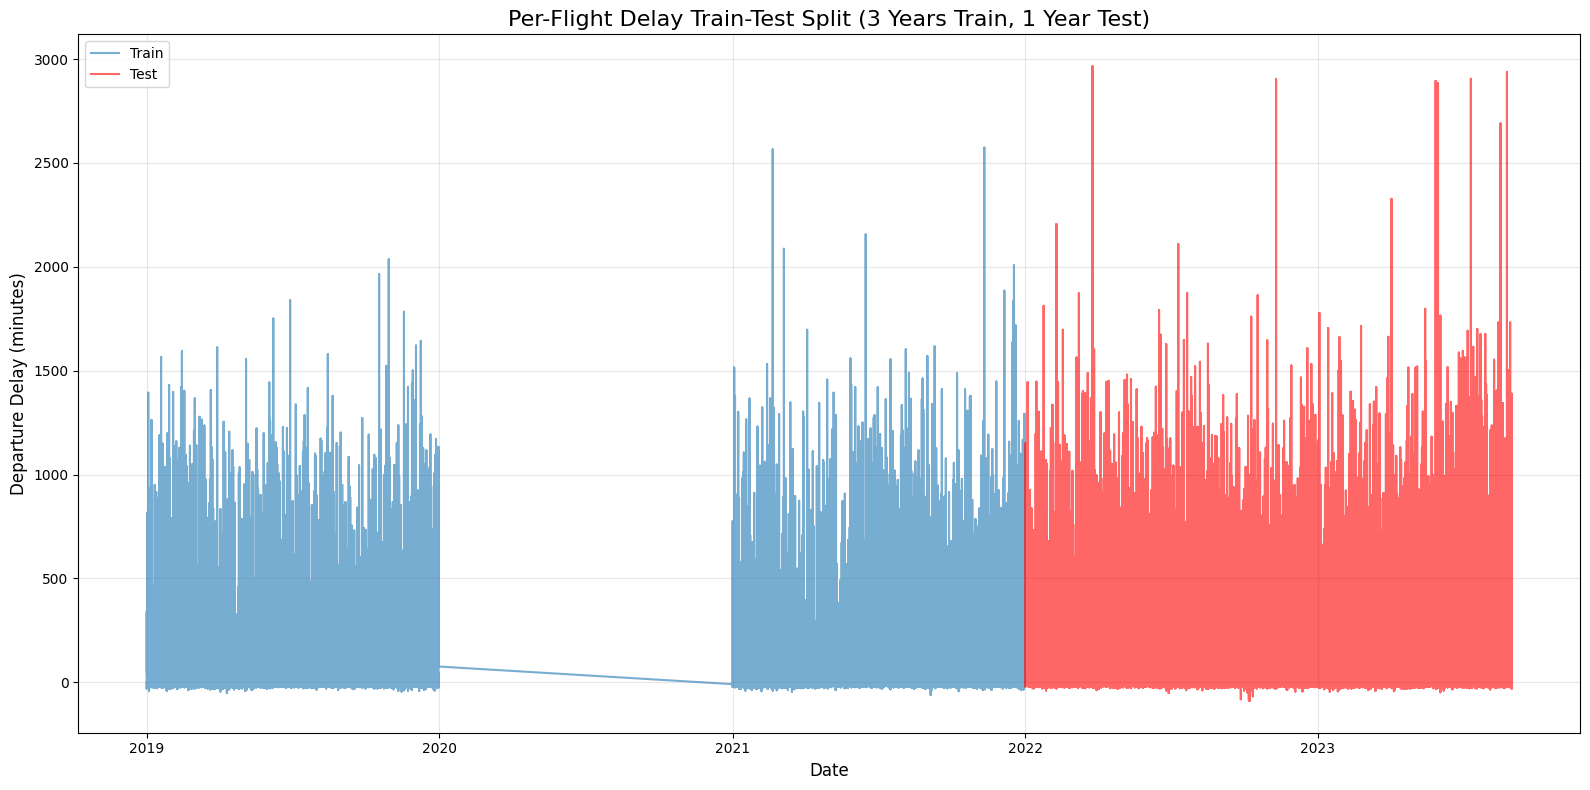

In [130]:
# --- Train/Test Split: 3 Years Train, 1 Year Test (Per-Flight Data) ---
# Load all base data in chunks and concatenate for per-flight granularity
all_chunks = []
for chunk in load_processed_data(BASE_PROCESSED_PATH):
    all_chunks.append(chunk)
df_full = pd.concat(all_chunks, ignore_index=True)

# Drop rows where all columns are identical (full duplicates)
df_full = df_full.loc[~df_full.duplicated(keep='first')]
print(f"Full per-flight dataset size after dropping full duplicates: {len(df_full)} rows")

# Sort by FL_DATE for chronological split
if 'FL_DATE' in df_full.columns:
    df_full = df_full.sort_values('FL_DATE').reset_index(drop=True)
    min_date = df_full['FL_DATE'].min()
    train_end = min_date + pd.DateOffset(years=3)
    test_start = train_end
    test_end = df_full['FL_DATE'].max()
    train_flight = df_full[df_full['FL_DATE'] < train_end]
    test_flight = df_full[(df_full['FL_DATE'] >= test_start) & (df_full['FL_DATE'] <= test_end)]
    print(f"Train set: {len(train_flight)} rows from {train_flight['FL_DATE'].min()} to {train_flight['FL_DATE'].max()}")
    print(f"Test set: {len(test_flight)} rows from {test_flight['FL_DATE'].min()} to {test_flight['FL_DATE'].max()}")
else:
    print("FL_DATE column not found in per-flight data.")

# Output per-flight delay (FL_DATE, DEP_DELAY, and any other relevant columns)
per_flight_delay = df_full[['FL_DATE', 'DEP_DELAY']].copy()
per_flight_delay = per_flight_delay.sort_values('FL_DATE').reset_index(drop=True)
print(f"Final per-flight delay output shape: {per_flight_delay.shape}")
display(per_flight_delay.head())

# Save per-flight delay output
# Ensure save_ts_data is defined above this cell
if 'save_ts_data' in globals():
    save_ts_data(per_flight_delay, "per_flight_delay_ts", TS_PROCESSED_PATH)
else:
    # Inline save logic if function is not defined yet
    os.makedirs(TS_PROCESSED_PATH, exist_ok=True)
    per_flight_delay.to_csv(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.csv"), index=False)
    per_flight_delay.to_pickle(os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.pkl"))
    print(f"Saved per_flight_delay_ts to {TS_PROCESSED_PATH}")

# Visualize the per-flight train/test split
plt.figure(figsize=(16, 8))
plt.plot(train_flight['FL_DATE'], train_flight['DEP_DELAY'], label='Train', alpha=0.6)
plt.plot(test_flight['FL_DATE'], test_flight['DEP_DELAY'], label='Test', color='red', alpha=0.6)
plt.title('Per-Flight Delay Train-Test Split (3 Years Train, 1 Year Test)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Departure Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# ...existing code for daily/aggregated splits and visualizations can remain below...

Train set: 640 days from 2019-01-01 to 2021-10-02
Validation set: 90 days from 2021-10-03 to 2021-12-31
Test set: 365 days from 2022-01-01 to 2022-12-31


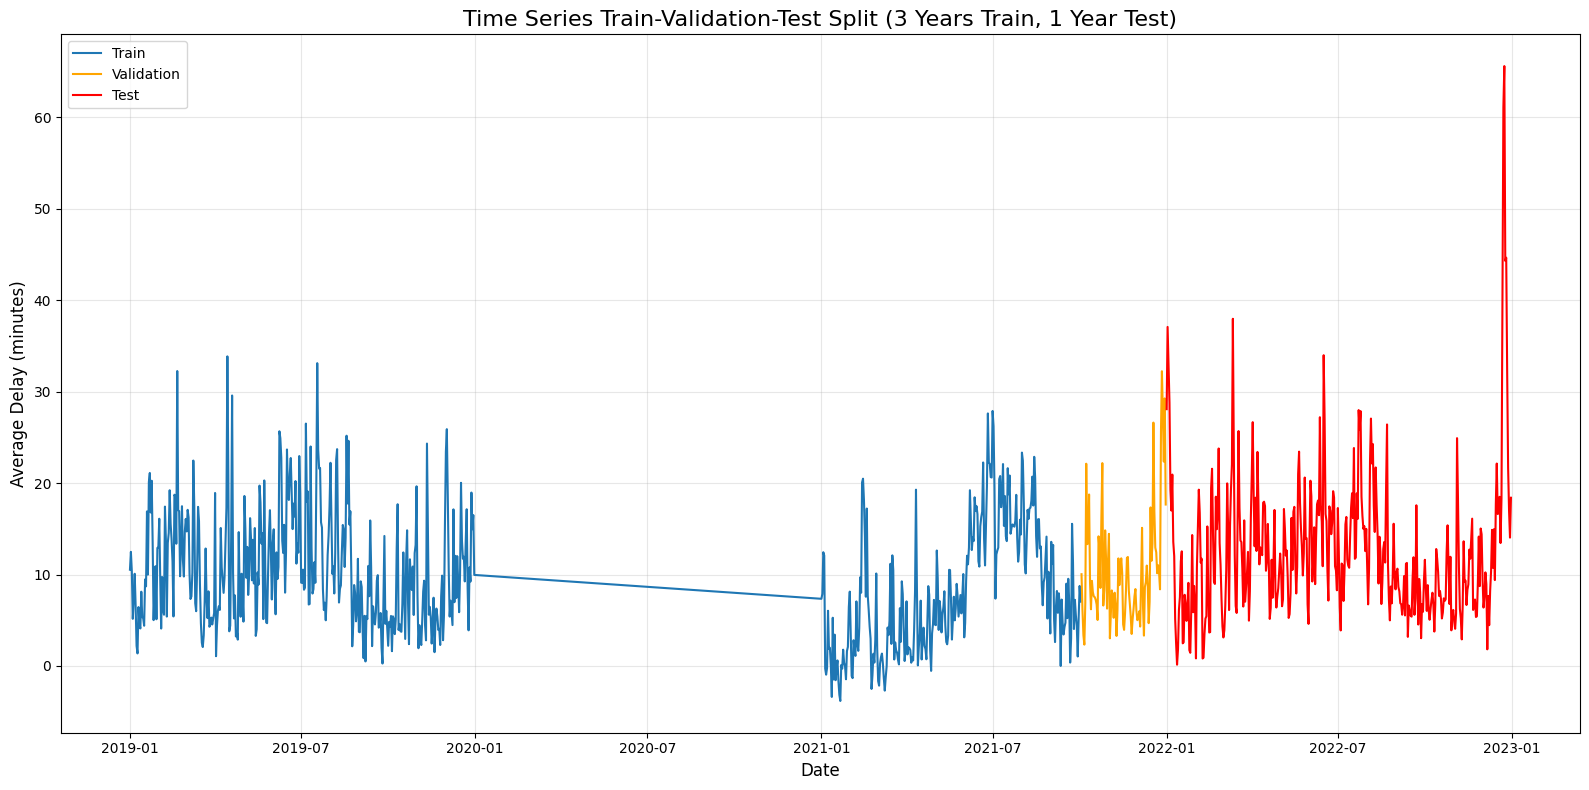

In [131]:
# --- Train/Test/Validation Split for Daily Time Series (3 Years Train, 1 Year Test) ---
# Ensure the index is a DatetimeIndex
if not isinstance(ts_daily_featured.index, pd.DatetimeIndex):
    ts_daily_featured.index = pd.to_datetime(ts_daily_featured.index)

# Sort by date
ts_sorted = ts_daily_featured.sort_index()
min_date = ts_sorted.index.min()
max_date = ts_sorted.index.max()

# Define split points
train_end = min_date + pd.DateOffset(years=3)
test_start = train_end
# Test set is 1 year after train_end, or up to max_date
if test_start + pd.DateOffset(years=1) <= max_date:
    test_end = test_start + pd.DateOffset(years=1) - pd.Timedelta(days=1)
else:
    test_end = max_date

# Optionally, define validation as last 3 months of train
val_days = 90
val_start = train_end - pd.Timedelta(days=val_days)

train_ts = ts_sorted[ts_sorted.index < val_start]
val_ts = ts_sorted[(ts_sorted.index >= val_start) & (ts_sorted.index < train_end)]
test_ts = ts_sorted[(ts_sorted.index >= test_start) & (ts_sorted.index <= test_end)]

print(f"Train set: {len(train_ts)} days from {train_ts.index[0].date()} to {train_ts.index[-1].date()}")
print(f"Validation set: {len(val_ts)} days from {val_ts.index[0].date()} to {val_ts.index[-1].date()}")
print(f"Test set: {len(test_ts)} days from {test_ts.index[0].date()} to {test_ts.index[-1].date()}")

# Visualize the splits
plt.figure(figsize=(16, 8))
plt.plot(train_ts.index, train_ts['avg_delay'], label='Train')
plt.plot(val_ts.index, val_ts['avg_delay'], label='Validation', color='orange')
plt.plot(test_ts.index, test_ts['avg_delay'], label='Test', color='red')
plt.title('Time Series Train-Validation-Test Split (3 Years Train, 1 Year Test)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Delay (minutes)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Airport-Level and Carrier-Level Time Series

For more granular forecasting, we'll also create aggregations at the airport and carrier level. This enables us to forecast delays for specific airports or carriers.

In [ ]:
# Create airport-level time series
ts_airport = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='airport_daily')

print(f"Airport-level time series shape: {ts_airport.shape}")
print(f"Number of airports: {len(ts_airport.index.levels[1])}")
print("\nFirst few rows:")
display(ts_airport.head())

# Get top airports by number of flights
top_airports = ts_airport.groupby(level=1)['num_flights'].sum().nlargest(5)
print("\nTop 5 airports by number of flights:")
print(top_airports)

In [ ]:
# Create carrier-level time series
try:
    ts_carrier = aggregate_to_time_series(load_processed_data(BASE_PROCESSED_PATH), agg_level='carrier_daily')
    if ts_carrier is not None:
        print(f"Carrier-level time series shape: {ts_carrier.shape}")
        print(f"Number of carriers: {len(ts_carrier.index.levels[1])}")
        print("\nFirst few rows:")
        display(ts_carrier.head())
        # Get top carriers by number of flights
        top_carriers = ts_carrier.groupby(level=1)['num_flights'].sum().nlargest(5)
        print("\nTop 5 carriers by number of flights:")
        print(top_carriers)
    else:
        print("Carrier-level time series could not be created. Check if required columns exist in the data.")
except Exception as e:
    print(f"Error creating carrier-level time series: {e}")

Error: OP_CARRIER column not found for carrier_daily aggregation
Carrier-level time series could not be created. Check if required columns exist in the data.
Per-flight delay output shape: (2470191, 2)
Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00

Sample per-flight delay data:
Per-flight delay output shape: (2470191, 2)
Date range: 2019-01-01 00:00:00 to 2023-08-31 00:00:00

Sample per-flight delay data:


,FL_DATE,DEP_DELAY
0,2019-01-01,-1.0
1,2019-01-01,-5.0
2,2019-01-01,2.0
3,2019-01-01,-2.0
4,2019-01-01,-6.0


In [ ]:
def save_ts_data(ts_data, name, output_dir):
    """
    Save time series data in multiple formats
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, f"{name}.csv")
    ts_data.to_csv(csv_path)
    pickle_path = os.path.join(output_dir, f"{name}.pkl")
    ts_data.to_pickle(pickle_path)
    print(f"Saved {name} to:")
    print(f"- CSV: {csv_path}")
    print(f"- Pickle: {pickle_path}")
    return csv_path, pickle_path

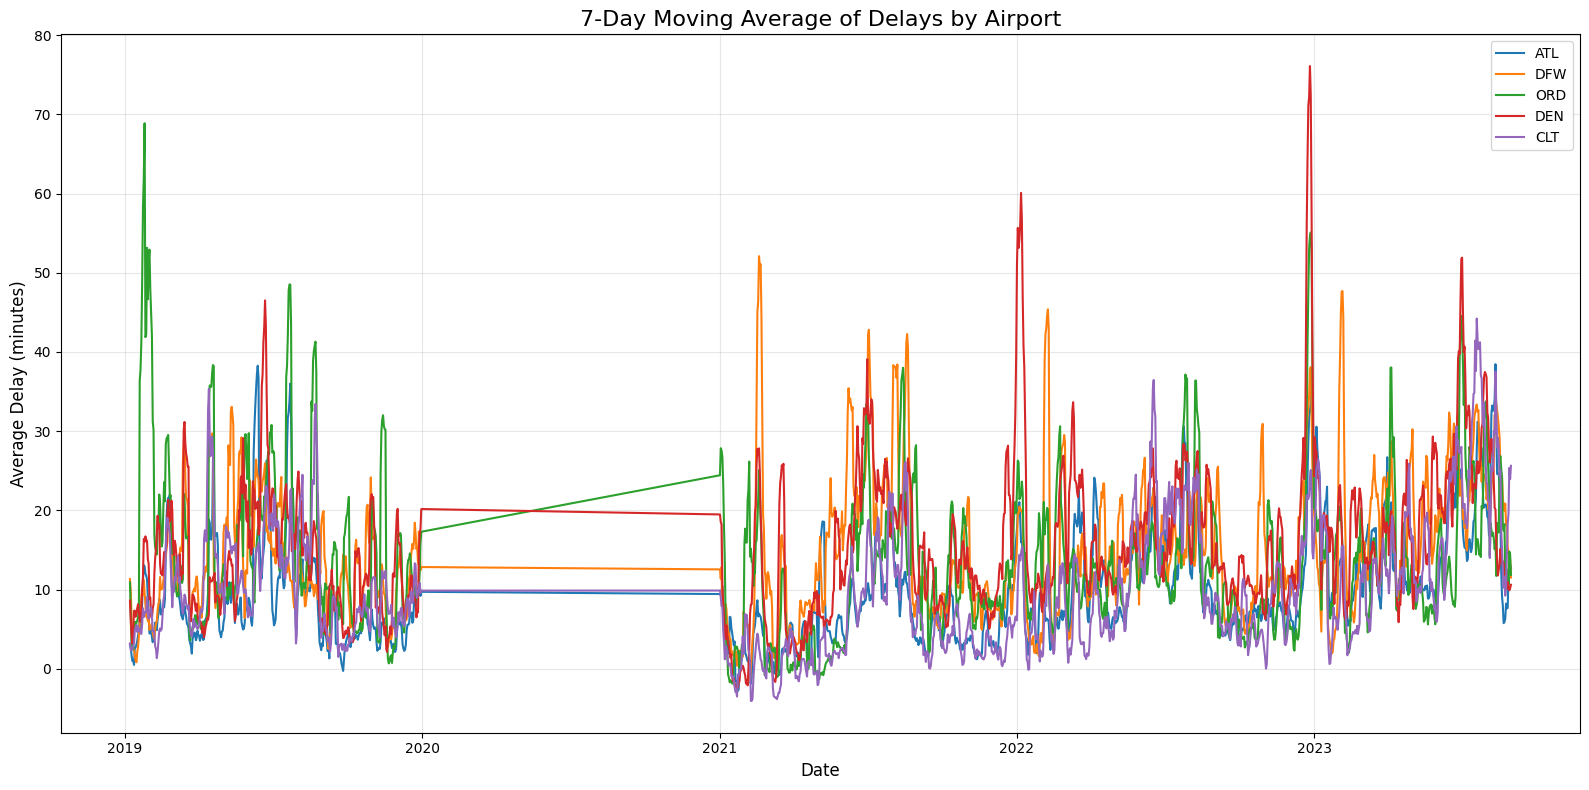

Saved daily_delay_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\daily_delay_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\daily_delay_ts.pkl
Saved airport_delay_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\airport_delay_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\airport_delay_ts.pkl
ts_carrier not available for saving.
Saved train_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\train_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\train_ts.pkl
Saved val_ts to:
- CSV: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\val_ts.csv
- Pickle: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\val_ts.pkl
Saved test_ts to:
- CSV: c:\xampp\htdoc

In [ ]:
# Visualize time series for top airports
if 'ts_airport' in locals() and 'top_airports' in locals() and not ts_airport.empty and not top_airports.empty:
    plt.figure(figsize=(16, 8))
    # Get top 5 airports
    top_5_airports = top_airports.index
    # Create a 7-day moving average for each airport
    for airport in top_5_airports:
        try:
            airport_data = ts_airport.xs(airport, level=1)
            plt.plot(airport_data.index, 
                     airport_data['avg_delay'].rolling(window=7).mean(), 
                     label=airport)
        except Exception as e:
            print(f"Error plotting {airport}: {e}")
    plt.title('7-Day Moving Average of Delays by Airport', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Average Delay (minutes)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Airport-level time series or top airports not available for plotting.")

# Save the daily time series with features
if 'ts_daily_featured' in locals() and not ts_daily_featured.empty:
    save_ts_data(ts_daily_featured, "daily_delay_ts", TS_PROCESSED_PATH)
else:
    print("ts_daily_featured not available for saving.")

# Save airport-level time series
if 'ts_airport' in locals() and not ts_airport.empty:
    save_ts_data(ts_airport, "airport_delay_ts", TS_PROCESSED_PATH)
else:
    print("ts_airport not available for saving.")

# Save carrier-level time series
if 'ts_carrier' in locals() and ts_carrier is not None and not ts_carrier.empty:
    save_ts_data(ts_carrier, "carrier_delay_ts", TS_PROCESSED_PATH)
else:
    print("ts_carrier not available for saving.")

# Save train-test-validation splits
if 'train_ts' in locals() and 'val_ts' in locals() and 'test_ts' in locals():
    if not train_ts.empty:
        save_ts_data(train_ts, "train_ts", TS_PROCESSED_PATH)
    if not val_ts.empty:
        save_ts_data(val_ts, "val_ts", TS_PROCESSED_PATH)
    if not test_ts.empty:
        save_ts_data(test_ts, "test_ts", TS_PROCESSED_PATH)
else:
    print("Train/validation/test splits not available for saving.")

## Time Series Cross-Validation

For time series, standard cross-validation isn't appropriate. We'll implement time series-specific cross-validation strategies.

In [ ]:
# Time series cross-validation function
def ts_cross_validation(ts_data, n_splits=3, test_days=7, val_days=7):
    """
    Create time series cross-validation folds
    
    Parameters:
    -----------
    ts_data : pandas.DataFrame
        Time series data with DatetimeIndex
    n_splits : int
        Number of validation folds to create
    test_days : int
        Number of days to include in each test fold
    val_days : int
        Number of days to include in each validation fold
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train, val, test) for a fold
    """
    # Sort the data by date
    ts_sorted = ts_data.sort_index()
    
    # Calculate the size of each fold
    fold_size = test_days + val_days
    
    # List to store the folds
    folds = []
    
    # Create folds
    for i in range(n_splits):
        # Calculate the end of this fold
        fold_end = ts_sorted.index[-1] - pd.Timedelta(days=i*fold_size)
        test_start = fold_end - pd.Timedelta(days=test_days)
        val_start = test_start - pd.Timedelta(days=val_days)
        
        # Create the train, validation, and test sets
        test = ts_sorted[(ts_sorted.index > test_start) & (ts_sorted.index <= fold_end)]
        val = ts_sorted[(ts_sorted.index > val_start) & (ts_sorted.index <= test_start)]
        train = ts_sorted[ts_sorted.index <= val_start]
        
        # Append to folds list
        folds.append((train, val, test))
    
    return folds

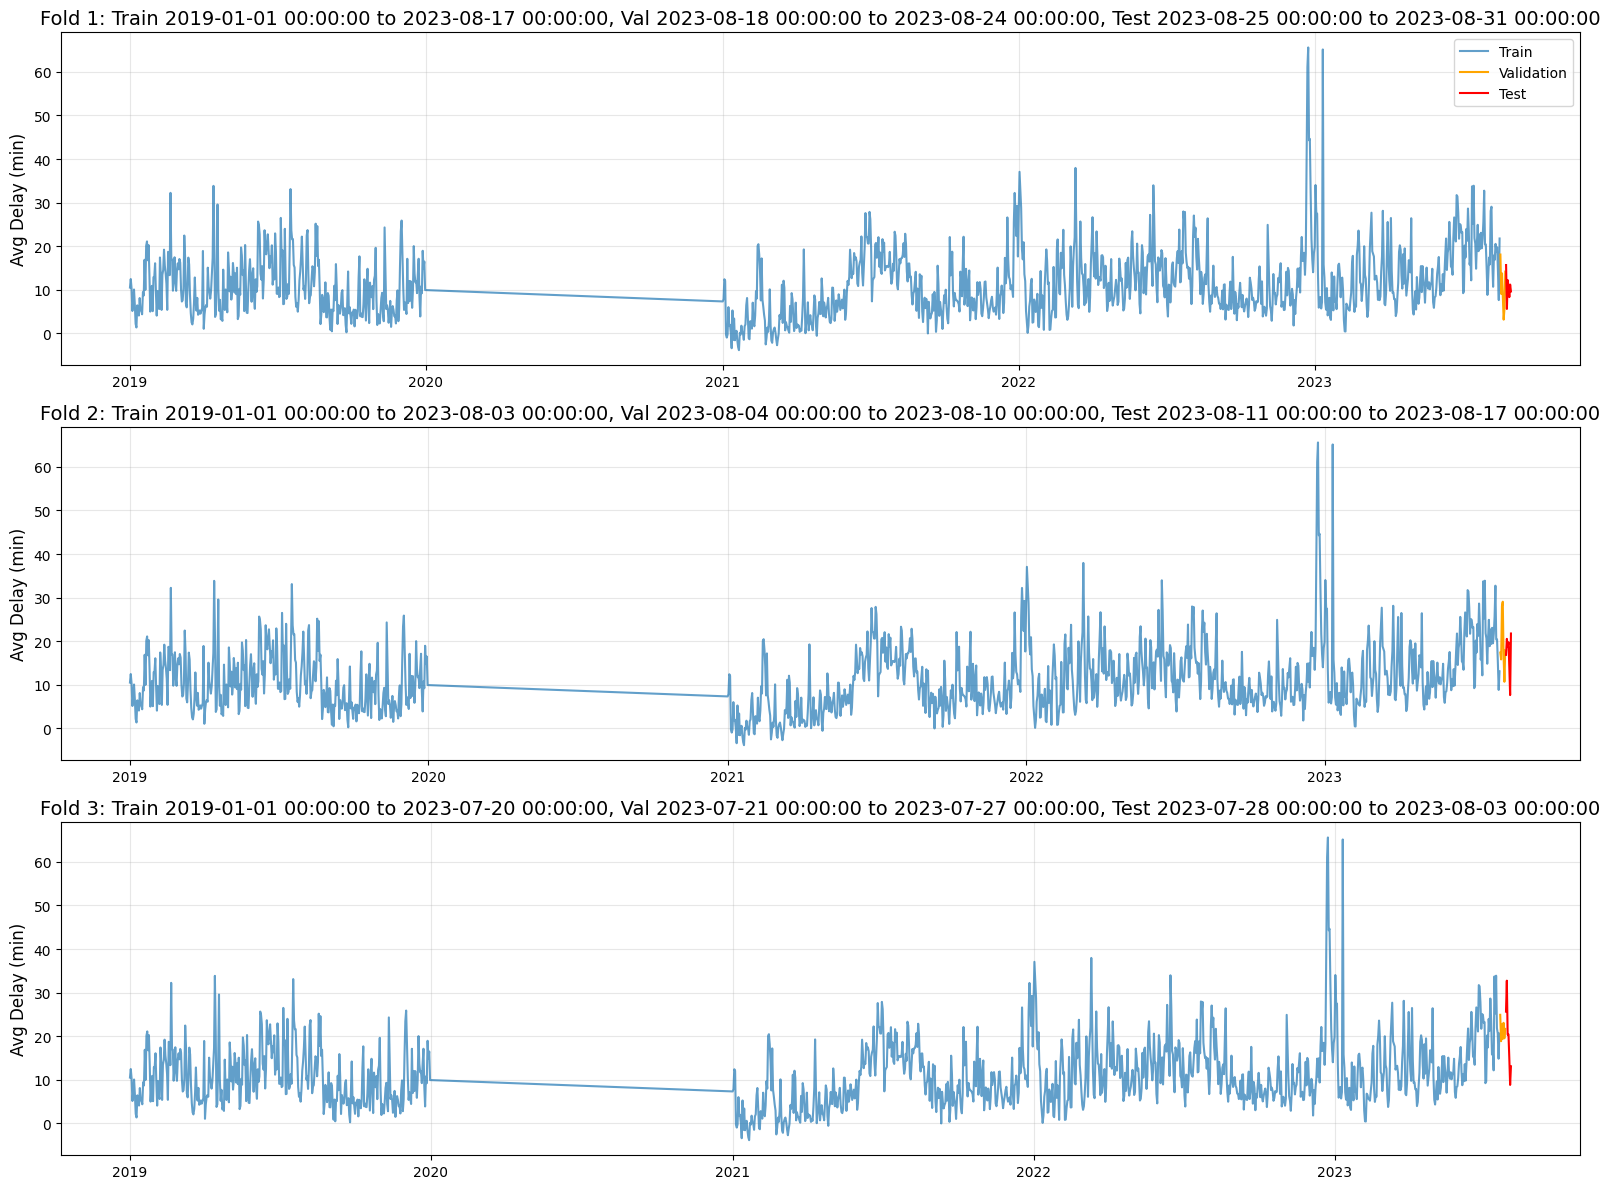

In [ ]:
# Demonstrate time series cross-validation
cv_folds = ts_cross_validation(ts_daily_featured, n_splits=3)

# Visualize CV folds
plt.figure(figsize=(16, 12))

for i, (train, val, test) in enumerate(cv_folds):
    plt.subplot(len(cv_folds), 1, i+1)
    
    plt.plot(train.index, train['avg_delay'], label='Train', alpha=0.7)
    plt.plot(val.index, val['avg_delay'], label='Validation', color='orange')
    plt.plot(test.index, test['avg_delay'], label='Test', color='red')
    
    plt.title(f'Fold {i+1}: Train {train.index[0]} to {train.index[-1]}, '
              f'Val {val.index[0]} to {val.index[-1]}, Test {test.index[0]} to {test.index[-1]}', 
              fontsize=14)
    plt.ylabel('Avg Delay (min)', fontsize=12)
    
    if i == 0:
        plt.legend()
    
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Create Model-Ready Data for Different Time Series Algorithms

Different time series models have different data format requirements. Let's prepare data specifically for:
1. ARIMA/SARIMA models
2. Prophet models
3. Neural network-based forecasting (e.g., LSTM)

In [ ]:
# Create data formatted for different time series algorithms

# 1. Format for ARIMA/SARIMA
def format_for_arima(ts_data, target_col='avg_delay'):
    """Format data for ARIMA/SARIMA models"""
    # For ARIMA, we typically need just the target variable as a series
    arima_data = ts_data[target_col].copy()
    
    # For SARIMAX with exogenous variables, we can include other features
    exog_cols = [col for col in ts_data.columns if col != target_col and
                col not in ['avg_delay_lag1', 'avg_delay_lag2', 'avg_delay_lag3']]  # Exclude lags
    
    # Create exogenous variables dataframe
    exog_data = ts_data[exog_cols].copy() if exog_cols else None
    
    return arima_data, exog_data

# 2. Format for Prophet
def format_for_prophet(ts_data, target_col='avg_delay'):
    """Format data for Facebook Prophet"""
    # Prophet requires a specific DataFrame format with 'ds' and 'y' columns
    prophet_data = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data[target_col]
    })
    
    # Add additional regressors (optional)
    for col in ts_data.columns:
        if col != target_col and 'lag' not in col:  # Exclude lags
            prophet_data[col] = ts_data[col]
    
    return prophet_data

# 3. Format for ML-based forecasting (LSTM)
def format_for_lstm(ts_data, target_col='avg_delay', seq_length=7):
    """Format data for LSTM models"""
    # For LSTM, we need sequences of data
    # Prepare the data
    data = ts_data.copy()
    
    # Create sequences
    X = []
    y = []
    
    for i in range(len(data) - seq_length):
        # Get sequence of features
        features = data.iloc[i:i+seq_length].drop(columns=[target_col])
        # Get target value (next day's value)
        target = data.iloc[i+seq_length][target_col]
        
        X.append(features.values)
        y.append(target)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Get feature names for reference
    feature_names = data.drop(columns=[target_col]).columns
    
    return X, y, feature_names

In [ ]:
# Create model-ready data examples using per-flight delay (DEP_DELAY) as the target

# Load per-flight delay data
per_flight_delay_path = os.path.join(TS_PROCESSED_PATH, "per_flight_delay_ts.pkl")
per_flight_delay = pd.read_pickle(per_flight_delay_path)

# Ensure FL_DATE is datetime and set as index
per_flight_delay['FL_DATE'] = pd.to_datetime(per_flight_delay['FL_DATE'])
per_flight_delay = per_flight_delay.set_index('FL_DATE').sort_index()

# Optionally, create features for per-flight delay (if needed for LSTM/Prophet)
per_flight_delay_featured = create_ts_features(per_flight_delay.rename(columns={'DEP_DELAY': 'avg_delay'}))

# Split per-flight delay data into train/test (3y train, 1y test)
min_date_pf = per_flight_delay_featured.index.min()
train_end_pf = min_date_pf + pd.DateOffset(years=3)
test_start_pf = train_end_pf
test_end_pf = per_flight_delay_featured.index.max()
train_pf = per_flight_delay_featured[per_flight_delay_featured.index < train_end_pf]
test_pf = per_flight_delay_featured[(per_flight_delay_featured.index >= test_start_pf) & (per_flight_delay_featured.index <= test_end_pf)]

# 1. Format for ARIMA/SARIMA (using per-flight delay)
arima_data_pf, arima_exog_pf = format_for_arima(train_pf, target_col='avg_delay')
print(f"ARIMA data shape (per-flight delay): {arima_data_pf.shape}")
if arima_exog_pf is not None:
    print(f"ARIMA exogenous data shape: {arima_exog_pf.shape}")

# 2. Format for Prophet (using per-flight delay)
prophet_data_pf = format_for_prophet(train_pf, target_col='avg_delay')
print(f"\nProphet data shape (per-flight delay): {prophet_data_pf.shape}")
print("Prophet data columns:", prophet_data_pf.columns.tolist()[:10], "...")

# 3. Format for LSTM (using per-flight delay)
lstm_X_pf, lstm_y_pf, lstm_features_pf = format_for_lstm(train_pf, target_col='avg_delay')
print(f"\nLSTM X shape (per-flight delay): {lstm_X_pf.shape}")
print(f"LSTM y shape (per-flight delay): {lstm_y_pf.shape}")
print(f"LSTM features: {len(lstm_features_pf)} columns")

ARIMA data shape (per-flight delay): (1345137,)
ARIMA exogenous data shape: (1345137, 31)

Prophet data shape (per-flight delay): (1345137, 29)
Prophet data columns: ['ds', 'y', 'avg_delay_roll_mean3', 'avg_delay_roll_std3', 'avg_delay_roll_max3', 'avg_delay_roll_min3', 'avg_delay_roll_mean7', 'avg_delay_roll_std7', 'avg_delay_roll_max7', 'avg_delay_roll_min7'] ...

LSTM X shape (per-flight delay): (1345130, 7, 34)
LSTM y shape (per-flight delay): (1345130,)
LSTM features: 34 columns

LSTM X shape (per-flight delay): (1345130, 7, 34)
LSTM y shape (per-flight delay): (1345130,)
LSTM features: 34 columns


In [ ]:
# Save model-ready data for per-flight delay

def save_model_ready_data(data_dict, output_dir):
    """Save model-ready data for different algorithms"""
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    # Save each item in the dictionary
    for name, data in data_dict.items():
        file_path = os.path.join(output_dir, f"{name}.pkl")
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"Saved {name} to {file_path}")

model_ready_data_pf = {
    'arima_data_per_flight': arima_data_pf,
    'arima_exog_per_flight': arima_exog_pf,
    'prophet_data_per_flight': prophet_data_pf,
    'lstm_data_per_flight': (lstm_X_pf, lstm_y_pf, lstm_features_pf)
}
save_model_ready_data(model_ready_data_pf, os.path.join(TS_PROCESSED_PATH, 'model_ready'))

Saved arima_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_data_per_flight.pkl
Saved arima_exog_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_exog_per_flight.pkl
Saved arima_exog_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\arima_exog_per_flight.pkl
Saved prophet_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\prophet_data_per_flight.pkl
Saved prophet_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\prophet_data_per_flight.pkl
Saved lstm_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_ready_flights\model_ready\lstm_data_per_flight.pkl
Saved lstm_data_per_flight to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\ts_read

## The above cells now use per-flight delay (DEP_DELAY) as the target variable for all model-ready data formats (ARIMA, Prophet, LSTM).